In [1]:
!python -V

Python 3.9.25


In [2]:
!pip install pyarrow

In [2]:
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pickle

In [21]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [11]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")



<Experiment: artifact_location='/workspaces/mlops-labs/03-training/experiment-tracking/mlruns/1', creation_time=1771858792383, experiment_id='1', last_update_time=1771858792383, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [13]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype(str)
    
    return df

In [14]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [15]:
len(df_train), len(df_val)

(73908, 61921)

In [18]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred, sample_weight=None, multioutput='uniform_average')

10.499110710357629

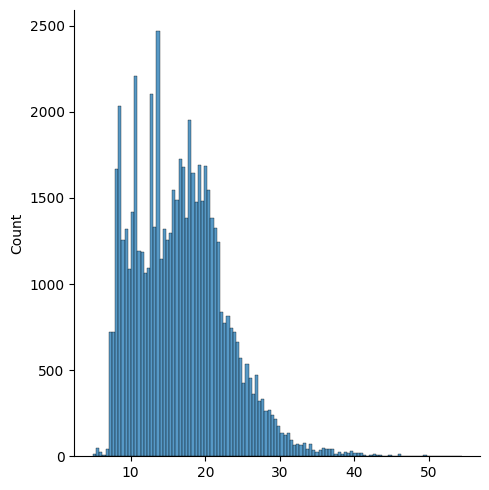

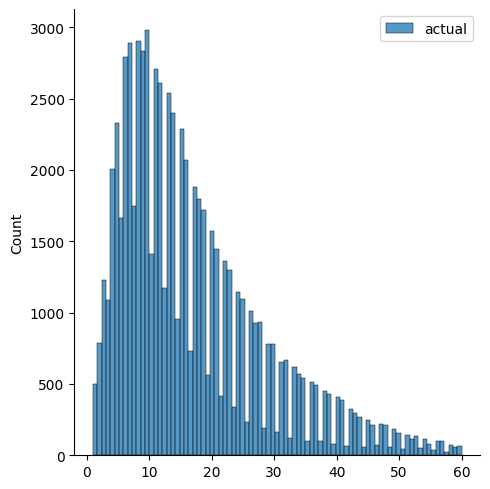

In [25]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [24]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [27]:
with mlflow.start_run():

    mlflow.set_tag("developer","antonio")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred, sample_weight=None, multioutput='uniform_average')

    mlflow.log_metric("rmse", rmse)